<a href="https://colab.research.google.com/github/kabeerbora/1980s_delin/blob/main/Panel_79_89_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
from tqdm.notebook import tqdm
import secrets
import string
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Data Loading and Cleaning

### Sampling and Data Collection

| **Scheme Code**                 | **Description**                                                                                                                              | **Standard Category** | **Reference** |
|--------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------|------------------------|---------------|
| **Complete Enumeration**        | Units selected for a complete count, typically large or significant units.                                                                   | Census                 | [ASI 1990-91 Metadata](https://microdata.gov.in/NADA/index.php/catalog/41/study-description) |
| **100 or more workers**         | Units employing 100 or more workers, often included in the census sector.                                                                   | Census                 | [ASI 1990-91 Metadata](https://microdata.gov.in/NADA/index.php/catalog/41/study-description) |
| **Sample I**                    | A subset of units selected for sampling, possibly based on specific criteria.                                                                | Sample                 | [ASI 1987-88 Documentation](https://microdata.gov.in/nada43/index.php/catalog/38/download/383) |
| **Sample II**                   | Another subset of units selected for sampling, possibly based on different criteria than Sample I.                                           | Sample                 | [ASI 1987-88 Documentation](https://microdata.gov.in/nada43/index.php/catalog/38/download/383) |
| **B & C 100 or more workers**   | Units in categories B & C with 100 or more workers.                                                                                          | Census                 | [ASI 1987-88 Documentation](https://microdata.gov.in/nada43/index.php/catalog/38/download/383) |
| **B & C–CE**                    | B & C category units under Complete Enumeration.                                                                                             | Census                 | [ASI 1987-88 Documentation](https://microdata.gov.in/nada43/index.php/catalog/38/download/383) |
| **B & C Sample I**              | B & C category units under Sample I.                                                                                                         | Sample                 | [ASI 1987-88 Documentation](https://microdata.gov.in/nada43/index.php/catalog/38/download/383) |
| **B & C Sample II**             | B & C category units under Sample II.                                                                                                        | Sample                 | [ASI 1987-88 Documentation](https://microdata.gov.in/nada43/index.php/catalog/38/download/383) |
| **Electricity**                 | Units primarily engaged in electricity generation or distribution.                                                                           | Census                 | [ASI 1990-91 Metadata](https://microdata.gov.in/NADA/index.php/catalog/41/study-description) |
| **NR**                          | Not Reported or Not Recorded.                                                                                                                | Exclude                | [ASI 1990-91 Metadata](https://microdata.gov.in/NADA/index.php/catalog/41/study-description) |

In [ ]:
data_file_path = r"/content/drive/MyDrive/data_economics_research/jan_weber_kabeer_bora/1976_1988_allfirms.csv"

df = pd.read_csv(data_file_path)

metric_columns = ["capital_open", "capital_closing", "work_cap_open", "work_cap_close", "outstanding_open", "outstanding_close", "semi_open", "semi_close"]

## 1. Cleaning and generating state code
df['state_code'] = df['state_code'].replace(['Daman and Diu'], 'DAMAN  &  DIU')
df['state_code'] = df['state_code'].replace(['Dadra & Nagar Haveli'], 'DADRA  AND  NAGAR  HAVELI')

unique_state_codes = df['state_code'].unique()
state_mapping = {code: i for i, code in enumerate(unique_state_codes)}
df['State'] = df['state_code'].map(state_mapping)

## 2. Filter census data
census_scheme_codes = map(lambda x: x.lower().strip(), [
    'Census', 'Complete Enumeration', '100 or more workers',
    'B & C 100 or more workers', 'B & C–CE', 'Electricity',
])
df = df[df['scheme_code'].str.lower().str.strip().isin(census_scheme_codes)]

# ## 3. Remove years
years_to_remove = ['1976_1977', '1977_1978','1989_1990', '1990_1991']
df = df[~df['year'].isin(years_to_remove)]

## 4. Get unique values from 'ownership_code' column
df['ownership_code'] = (
    df['ownership_code']
    .astype(str)
    .str.strip()
    .str.replace(r'\s+', ' ', regex=True)
    .str.lower()
)

ownership_code_mapping = {
    'wholly private enterprise': 1,
    'wholly private ownership': 1,
    'wholly central government': 2,
    'wholly state and/or local government': 3,
    'central government and state and/or local government jointly': 4,
    'central government and state and/or local government joint': 4,
    'joint sector public': 5,
    'joint sector private': 6,
    'invalid': 7,
    '7.0': 7
}

df['ownership_code_unique'] = df['ownership_code'].map(ownership_code_mapping)

unmatched = df[df['ownership_code_unique'].isna()]['ownership_code'].unique()
print("Unmatched ownership_code values:\n", unmatched)

## 5. Generate Identifier
df['identifier'] = df['nic_code'].astype(str).str[:4] + '_' + \
                   df['ownership_code_unique'].fillna('nan').astype(str) + '_' + \
                   df['State'].astype(str)

df = df.loc[(df['capital_open'] != 0) | (df['capital_closing'] != 0)].copy()

## 6. Convert all numerical columns to integer type
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(value=0).astype(int)

print(df.shape)
df = df.reset_index(drop=True)
df = df.reset_index(names=['ROW_ID'])

df.head(5)

Unmatched ownership_code values:
 []
(229685, 28)


,ROW_ID,state_code,rsl,nic_code,ownership_code,organization_code,scheme_code,district_code,year_initial,capital_open,...,semi_open,semi_close,bonus_workers,tot_emoluments,K_formation,year,gross_sales,State,ownership_code_unique,identifier
0,0,RAJASTHAN,285,2010,wholly private enterprise,Co-Operative Society,Census,6,1977,3570028,...,0,0,29193,725816,968091,1979_1980,0,0,1,2010_1_0
1,1,RAJASTHAN,292,2010,wholly private enterprise,Partnership : Others,Census,6,1972,11851035,...,211526,263782,0,1736471,2808576,1979_1980,0,0,1,2010_1_0
2,2,RAJASTHAN,161,2010,wholly state and/or local government,Public Corporations,Census,12,1965,1140958,...,0,0,36006,861077,-173365,1979_1980,0,0,3,2010_3_0
3,3,RAJASTHAN,264,2010,wholly private enterprise,Co-Operative Society,Census,12,1972,4434960,...,0,0,25220,728636,758476,1979_1980,0,0,1,2010_1_0
4,4,RAJASTHAN,202,2010,joint sector public,Co-Operative Society,Census,25,1975,1132327,...,0,0,3600,136342,36154,1979_1980,0,0,5,2010_5_0


## 2. Creating Panel

Desired Output


| firm_Id  | period     | capital         | work           | outstanding      | semi           | year_initial | identifier | source_ROW_IDs       |
|----------|------------|------------------|----------------|------------------|----------------|---------------|------------|-----------------------|
| ZHY8H7FJ | 1979-1983  | 100,200,300,400  | 250,650,100,150| 500,600,700,800  | 0,1,0,1        | 1957          | 2000_1_3   | 2004,2005,2006,2007   |
| AQW9T2KL | 1980-1984  | 150,250,350,450  | 200,300,400,500| 550,650,750,850  | 1,0,1,0        | 1957          | 2000_1_4   | 2010,2011,2012,2013   |
| MNB3X9CY | 1981-1985  | 120,220,320,420  | 260,360,460,560| 520,620,720,820  | 0,0,1,1        | 1957          | 2000_1_5   | 2020,2021,2022,2023   |
| TYU7P6RE | 1982-1986  | 130,230,330,430  | 270,370,470,570| 530,630,730,830  | 1,1,0,0        | 1957          | 2000_1_6   | 2030,2031,2032,2033   |


### 2.1 Extract all the years

In [ ]:
years = sorted(df['year'].unique())
print(years)

['1979_1980', '1980_1981', '1981_1982', '1982_1983', '1983_1984', '1984_1985', '1985_1986', '1986_1987', '1987_1988', '1988_1989']


### 2.2 Helper Functions

In [ ]:
def standardise_dataframes(df, py_year, cy_year):

    ## 1. Extract data
    PY_df = df[df['year']==py_year].copy()
    CY_df = df[df['year']==cy_year].copy()

    ## 2. Standardize Current Year Dataframe
    CY_drop_columns = ['capital_closing', 'work_cap_close', 'outstanding_close', 'semi_close']
    CY_df = CY_df.drop(CY_drop_columns, axis=1)

    CY_rename_dict = {
        'capital_open': 'capital',
        'work_cap_open': 'work_cap',
        'outstanding_open': 'outstanding',
        'semi_open': 'semi'
    }
    CY_df = CY_df.rename(columns = CY_rename_dict)
    CY_df = CY_df.drop_duplicates(subset = ["year_initial", "capital", "work_cap", "outstanding", "semi"])

    ## 3. Standardize Previous Year Dataframe
    PY_drop_columns = ['capital_open', 'work_cap_open', 'outstanding_open', 'semi_open']
    PY_df = PY_df.drop(PY_drop_columns, axis=1)
    PY_rename_dict = {
        'capital_closing': 'capital',
        'work_cap_close': 'work_cap',
        'outstanding_close': 'outstanding',
        'semi_close': 'semi'
    }

    PY_df = PY_df.rename(columns = PY_rename_dict)
    PY_df = PY_df.drop_duplicates(subset = ["year_initial", "capital", "work_cap", "outstanding", "semi"])

    return CY_df, PY_df

### 2.3 Match Row IDs

Match row IDS by `opening` and `closing` values along with `identifier`, `year_initial` etc of consecutive years

In [ ]:
import pandas as pd

df_clean = df.copy()
columns_to_drop = [
    'state_code', 'rsl', 'nic_code', 'ownership_code', 'organization_code',
    'scheme_code', 'district_code', 'gross_sales', 'State', 'ownership_code_unique',
    'tot_emoluments', 'bonus_workers', 'wages', 'tot_output', 'value_added',
    'persons_engaged'
]
df_clean = df_clean.drop(columns_to_drop, axis=1).copy()

matched_row_ids = []

for i in range(len(years) - 1):

    # 1. Extract years
    py_year, cy_year = years[i], years[i + 1]

    # 2. Standardize
    CY_df, PY_df = standardise_dataframes(df_clean, py_year, cy_year)

    # 3. Merge on identifier and year_initial (exact), then match on tolerances
    merged = CY_df.merge(
        PY_df,
        on=['identifier', 'year_initial'],
        suffixes=('_CY', '_PY'),
        how='inner'
    )

    # 4. Apply tolerance filter
    condition = (
        (abs(merged['capital_CY'] - merged['capital_PY']) <= 1000) &
        (abs(merged['work_cap_CY'] - merged['work_cap_PY']) <= 1000) &
        (abs(merged['outstanding_CY'] - merged['outstanding_PY']) <= 1000) &
        (abs(merged['semi_CY'] - merged['semi_PY']) <= 1000)
    )

    matched = merged[condition]

    # 5. Store matched row ids
    matched_row_id = list(zip(matched['ROW_ID_PY'], matched['ROW_ID_CY']))
    matched_row_ids.append(matched_row_id)

In [ ]:
import pandas as pd
import numpy as np

df_clean = df.copy()
columns_to_drop = [
    'state_code', 'rsl', 'nic_code', 'ownership_code', 'organization_code',
    'scheme_code', 'district_code', 'gross_sales', 'State', 'ownership_code_unique',
    'tot_emoluments', 'bonus_workers', 'wages', 'tot_output', 'value_added',
    'persons_engaged'
]
df_clean = df_clean.drop(columns_to_drop, axis=1).copy()

matched_row_ids = []

def truncate_to_6_digits(series):
    return (series // 10**(max(series.abs().astype(int).apply(lambda x: len(str(x))) - 6, default=0))).astype(int)

for i in range(len(years) - 1):

    py_year, cy_year = years[i], years[i + 1]

    CY_df, PY_df = standardise_dataframes(df_clean, py_year, cy_year)

    # Truncate to 6-digit levels
    for var in ['capital', 'work_cap', 'outstanding', 'semi']:
        CY_df[f'{var}_6'] = truncate_to_6_digits(CY_df[var])
        PY_df[f'{var}_6'] = truncate_to_6_digits(PY_df[var])

    # Merge on identifier, year_initial, and 6-digit truncated values
    merged = CY_df.merge(
        PY_df,
        on=[
            'identifier', 'year_initial',
            'capital_6', 'work_cap_6', 'outstanding_6', 'semi_6'
        ],
        suffixes=('_CY', '_PY'),
        how='inner'
    )

    # Collect matched row IDs
    matched_row_id = list(zip(merged['ROW_ID_PY'], merged['ROW_ID_CY']))
    matched_row_ids.append(matched_row_id)

### 2.4 Merge Common Row IDS

- Now once the common row_ids are found, merge them into one single row
- That way we can get the unique firms

In [ ]:
def merge_row_ids(ROW_IDS_PY, ROW_IDS_CY):

    a_dict = dict([(a[:-1], a[-1]) for a in ROW_IDS_PY])
    b_dict = dict([(b[:-1], b[-1]) for b in ROW_IDS_CY])
    merge_counts = 0

    C = []

    for a in ROW_IDS_PY:
        search_key = (a[-1],)
        if search_key in b_dict.keys():
            C.append(a+(b_dict[search_key],))
            merge_counts +=1
        else:
            C.append(a)

    unused_B = [b for b in ROW_IDS_CY if b[0] not in a_dict.values()]
    C.extend(unused_B)

    return C, merge_counts

In [ ]:
%%time
for i in tqdm(range(len(matched_row_ids))):
    print(f"Iteration: {i}")
    if i == 0:
        ROW_IDS_PY = matched_row_ids[i]
        ROW_IDS_CY = matched_row_ids[i+1]
        PY_row_id = i
        CY_row_id = i+1
        print(f"PY matched row ids: {PY_row_id}")
    elif i == 1:
        ## Skip this iteration as it was already merged
        continue
    else:
        ROW_IDS_CY = matched_row_ids[i]
        CY_row_id = i

    ROW_IDS_PY, merge_counts = merge_row_ids(ROW_IDS_PY, ROW_IDS_CY)
    print(f"Total merge counts: {merge_counts}")

print("-"*100)
print(f"Total unique firms found: {len(ROW_IDS_PY)}")

  0%|          | 0/9 [00:00<?, ?it/s]

Iteration: 0
PY matched row ids: 0
Total merge counts: 7382
Iteration: 1
Iteration: 2
Total merge counts: 8790
Iteration: 3
Total merge counts: 10378
Iteration: 4
Total merge counts: 10388
Iteration: 5
Total merge counts: 8658
Iteration: 6
Total merge counts: 12513
Iteration: 7
Total merge counts: 5758
Iteration: 8
Total merge counts: 3344
----------------------------------------------------------------------------------------------------
Total unique firms found: 51843
CPU times: user 44.8 s, sys: 51.9 ms, total: 44.8 s
Wall time: 45.5 s


### 2.5 Concat the results

In [ ]:
%%time
rows_data = []
count = 0
for row_ids in tqdm(ROW_IDS_PY, unit="rows", total=len(ROW_IDS_PY)):

    x_row_df = df_clean[df_clean["ROW_ID"].isin(row_ids)].copy()

    data = {}

    ## 1. Extract the metadata values
    year_initial, year, identifier = x_row_df.iloc[0][['year_initial', 'year', 'identifier']]
    data['year_initial'] = int(year_initial)
    data['identifier'] = identifier
    data['row_ids'] = row_ids

    ## 2. Extract year range
    y = x_row_df[['year']].copy()
    y[['from', 'to']] = y['year'].str.split("_").tolist()
    data['year_from'] = y['from'].iloc[0]
    data['year_to'] = y['to'].iloc[-1]

    ## 3. Extract all the macro values
    data["capital"] = x_row_df["capital_open"].tolist() + [x_row_df["capital_closing"].tolist()[-1]]
    data["work_cap"] = x_row_df["work_cap_open"].tolist() + [x_row_df["work_cap_close"].tolist()[-1]]
    data["outstanding"] = x_row_df["outstanding_open"].tolist() + [x_row_df["outstanding_close"].tolist()[-1]]
    data["semi"] = x_row_df["semi_open"].tolist() + [x_row_df["semi_close"].tolist()[-1]]

    rows_data.append(data)

df_final = pd.DataFrame(rows_data)

  0%|          | 0/51843 [00:00<?, ?rows/s]

CPU times: user 4min 59s, sys: 1.15 s, total: 5min
Wall time: 5min 4s


## Assigning Unique Firm IDs

In [ ]:
all_row_ids = []
for i, row_ids in tqdm(enumerate(df_final['row_ids']), total=len(df_final['row_ids']), unit="row_ids"):

  firm_id = f"firm_{i}"
  # Create a list of dictionaries for the DataFrame
  data_list = []
  for row_id in row_ids:
    data_list.append({'ROW_ID': row_id, 'firm_Id': firm_id})

  # Create the DataFrame
  firm_df = pd.DataFrame(data_list)
  all_row_ids.append(firm_df)

all_row_ids = pd.concat(all_row_ids)
all_row_ids.head()

  0%|          | 0/51843 [00:00<?, ?row_ids/s]

,ROW_ID,firm_Id
0,1,firm_0
1,19335,firm_0
0,2,firm_1
1,19336,firm_1
0,4,firm_2


In [ ]:
df_with_unique_firm = pd.merge(
    left = all_row_ids,
    right = df,
    on = "ROW_ID",
    how = "left"
)
df_with_unique_firm.tail(10)

,ROW_ID,firm_Id,state_code,rsl,nic_code,ownership_code,organization_code,scheme_code,district_code,year_initial,...,semi_open,semi_close,bonus_workers,tot_emoluments,K_formation,year,gross_sales,State,ownership_code_unique,identifier
170887,204332,firm_51838,KARNATAKA,954,4200,wholly state and/or local government,Public Corporations,Complete Enumeration,5,1964,...,0,0,0,964644,492180,1987_1988,5536884,25,3,4200_3_25
170888,229443,firm_51838,KARNATAKA,2342,4200,wholly state and/or local government,"Others (including trusts, wakf, boards etc.)",Complete Enumeration,16,1964,...,0,0,0,537085,0,1988_1989,4796691,25,3,4200_3_25
170889,204333,firm_51839,KARNATAKA,517,4200,wholly state and/or local government,Public Corporations,Complete Enumeration,5,1965,...,0,0,0,92460,0,1987_1988,0,25,3,4200_3_25
170890,229444,firm_51839,KARNATAKA,2458,4200,wholly state and/or local government,"Others (including trusts, wakf, boards etc.)",Complete Enumeration,16,1965,...,0,0,0,177476,895,1988_1989,237307,25,3,4200_3_25
170891,204337,firm_51840,KARNATAKA,374,4200,wholly state and/or local government,Public Corporations,Complete Enumeration,19,1936,...,0,0,0,463490,0,1987_1988,1060406,25,3,4200_3_25
170892,229446,firm_51840,KARNATAKA,2196,4200,wholly state and/or local government,Government departmental enterprises,Complete Enumeration,19,1936,...,0,0,0,258596,0,1988_1989,907004,25,3,4200_3_25
170893,204339,firm_51841,KARNATAKA,304,9730,wholly state and/or local government,Public Corporations,100 or more workers,1,1940,...,0,0,445200,8773495,0,1987_1988,0,25,3,9730_3_25
170894,229452,firm_51841,KARNATAKA,1760,9730,wholly state and/or local government,Public Corporation by special Act of Parliamen...,100 or more workers,1,1940,...,0,0,649675,9091610,0,1988_1989,0,25,3,9730_3_25
170895,204345,firm_51842,KARNATAKA,496,9730,wholly state and/or local government,Public Corporations,100 or more workers,2,1950,...,0,0,209057,3754158,0,1987_1988,0,25,3,9730_3_25
170896,229459,firm_51842,KARNATAKA,2309,9730,wholly state and/or local government,Government departmental enterprises,100 or more workers,2,1950,...,0,0,222914,4045231,0,1988_1989,0,25,3,9730_3_25


In [ ]:
df_with_unique_firm['Year'] = df_with_unique_firm['year'].str[:4].astype(int)
df_panel = df_with_unique_firm.sort_values(by=['firm_Id', 'Year']).copy()

In [ ]:
df_panel['rate_of_profit'] = (
    (df_panel['value_added'] - df_panel['tot_emoluments']) / df_panel['capital_open']
)
df_filtered = df_panel[
    (df_panel['rate_of_profit'] <= 1) &
    (df_panel['rate_of_profit'] > 0) &
    (df_panel['rate_of_profit'].notna())
].copy()
print("\nShape of filtered panel dataframe:")
print(df_filtered.shape)

print("\nDescription of 'rate_of_profit' in filtered panel dataframe:")
print(df_filtered['rate_of_profit'].describe())

In [ ]:
df_panel.to_csv('/content/drive/MyDrive/data_economics_research/jan_weber_kabeer_bora/panel_79_88.csv', index=False)

df_with_unique_firm# 3. Creating delicensing sectors



In [ ]:
# nic_codes_to_check = [
#     274, 269, 268, 267, 266, 265, 264, 262, 261, 260, 259, 258, 257, 254, 250, 248, 247, 246, 245,
#     243, 242, 241, 240, 236, 235, 234, 233, 232, 231, 230, 224, 218, 216, 215, 214, 213, 209, 208,
#     205, 201, 200, 389, 387, 386, 385, 384, 383, 382, 381, 379, 378, 372, 370, 362, 361, 349, 345,
#     340, 336, 335, 334, 333, 332, 329, 326, 325, 324, 317, 311, 303, 301, 296, 295, 291, 288, 287,
#     284, 279, 277, 276, 275
# ]
nic_codes_to_check = [
    274, 269, 268, 267, 266, 265, 262, 261, 260, 252, 251, 250, 248, 247, 246, 245, 243, 241, 242,
    240, 232, 231, 236, 235, 234, 233, 230, 224, 217, 215, 214, 212, 209, 208, 205, 201, 200,
    389, 387, 386, 385, 384, 383, 382, 381, 379, 378, 372, 373, 370, 362, 361, 349, 344, 341, 336,
    335, 334, 333, 332, 329, 326, 325, 324, 301, 296, 295, 291, 288, 287, 284, 279, 277, 276, 275
]
df_panel['nic_3digit'] = df_panel['nic_code'].astype(str).str[:3]
nic_codes_str = [str(code) for code in nic_codes_to_check]
df_panel['delicensed'] = (
    (df_panel['nic_3digit'].isin(nic_codes_str)) &
    (df_panel['Year'] >= 1985)
).astype(int)
print(df_panel['delicensed'].value_counts())

delicensed
0    160200
1     10697
Name: count, dtype: int64


## Plotting distributions of rates of profit

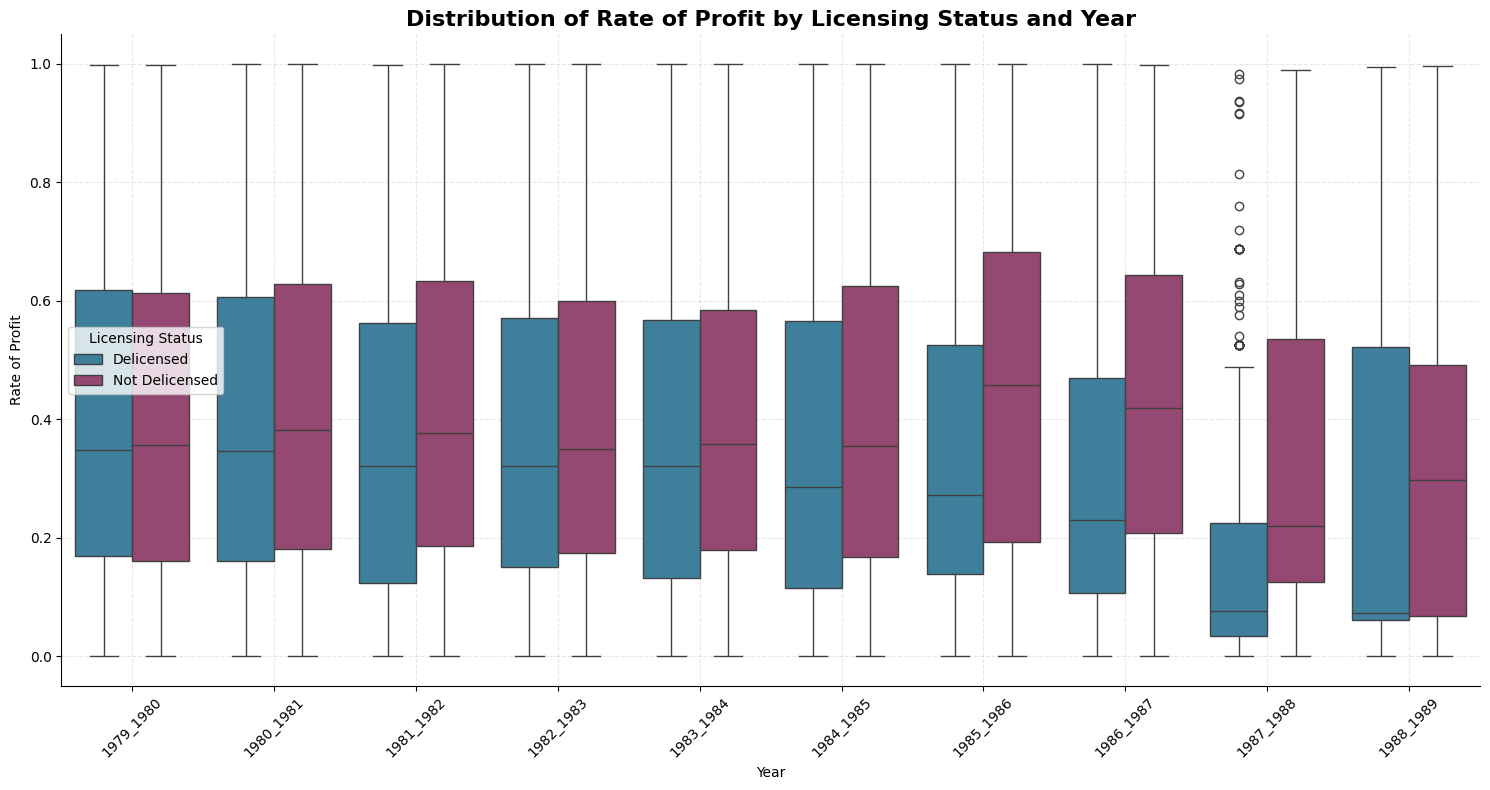

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df_filtered['Licensing Status'] = df_filtered['delicensed'].map({1: 'Delicensed', 0: 'Not Delicensed'})
df_filtered_sorted = df_filtered.sort_values(by='year')
plt.figure(figsize=(15, 8)) # Adjust figure size as needed
sns.boxplot(data=df_filtered_sorted, x='year', y='rate_of_profit', hue='Licensing Status',
            palette=['#2E86AB', '#A23B72'])
plt.title('Distribution of Rate of Profit by Licensing Status and Year', fontsize=16, weight='bold')
plt.xlabel('Year')
plt.ylabel('Rate of Profit')
plt.grid(True, linestyle='--', alpha=0.3)
sns.despine()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()